<a href="https://colab.research.google.com/github/vincelemke99/Bachelor-Thesis/blob/main/finales_lead_predication_target_encoder_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pandas category_encoders scikit-learn tensorflow --q
!pip install tensorflow==2.12.0 --q


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import machine learning libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [ ]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data'

In [ ]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [ ]:
df.shape

(210811, 18)

In [ ]:
df.head()

,Lead_ID,Lead_Source,Lead_Source_Detail,Name_Case,Domain_Type,Gender,Host,has_Phone,Accept_Data_Policy,Conversion_Type,Study_Model,Type_of_Study_Program,Study_Location,Faculty,Study_Program,Semester,is_converted,Sum_of_Study_Interests
0,00Q7U000003RdpLUAS,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,00Q7U000005NeSiUAK,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,00Q7U0000034VNWUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,00Q7U000006uQDGUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,00Q7U000008l7alUAA,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [ ]:
df.drop(['Lead_ID',], axis="columns", inplace=True)

In [ ]:
df.rename(columns={'Lead_Source' : 'Lead Source', 'Lead_Source_Detail' : 'Lead Source Detail',
                   'Name_Case' : 'Name Case', 'has_Phone' : 'has Phone', 'Accept_Data_Policy' : 'Accept Data Policy',
                   'Conversion_Type' : 'Conversion Type', 'Study_Model' : 'Study Model', 'Type_of_Study_Program' : 'Type of Study Program',
                   'Study_Location' : 'Study Location', 'Study_Program' : 'Study Program', 'Sum_of_Study_Interests' : 'Sum of Study Interests' , 'Domain_Type' : 'Domain Type' },inplace=True)


In [ ]:
df.head()

,Lead Source,Lead Source Detail,Name Case,Domain Type,Gender,Host,has Phone,Accept Data Policy,Conversion Type,Study Model,Type of Study Program,Study Location,Faculty,Study Program,Semester,is_converted,Sum of Study Interests
0,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [ ]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Host,40591
Conversion Type,39412
Gender,3738
Type of Study Program,0
is_converted,0
Semester,0
Study Program,0
Faculty,0
Study Location,0
Lead Source,0


In [ ]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Host,19.254688
Conversion Type,18.695419
Gender,1.773152
Type of Study Program,0.000000
is_converted,0.000000
Semester,0.000000
Study Program,0.000000
Faculty,0.000000
Study Location,0.000000
Lead Source,0.000000


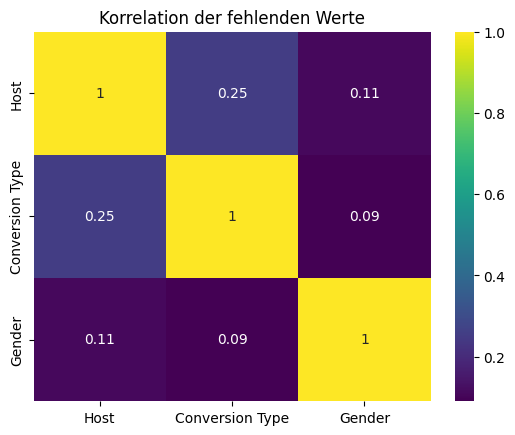

In [ ]:
# Korrelation zwischen den fehlenden Werten
correlation_matrix = df[['Host', 'Conversion Type', 'Gender']].isnull().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Korrelation der fehlenden Werte')
plt.show()


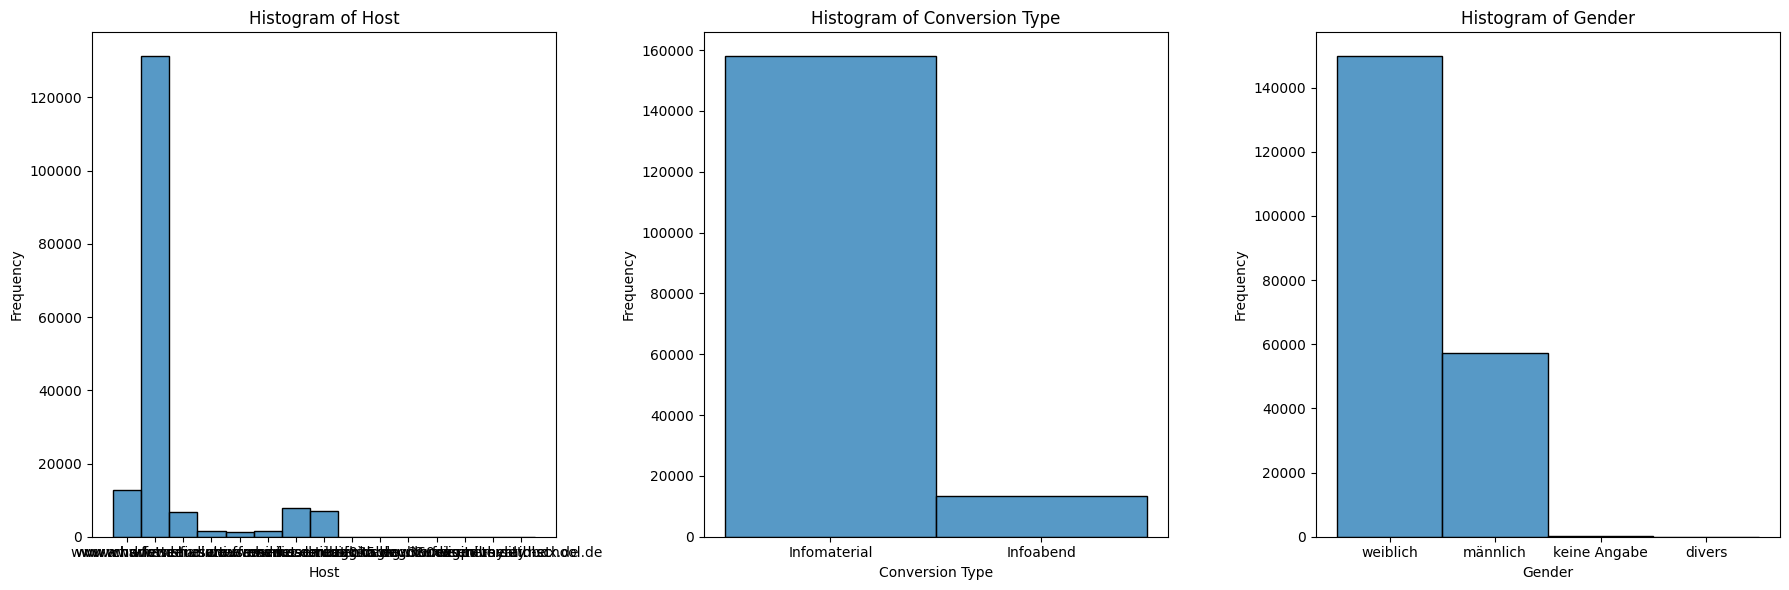

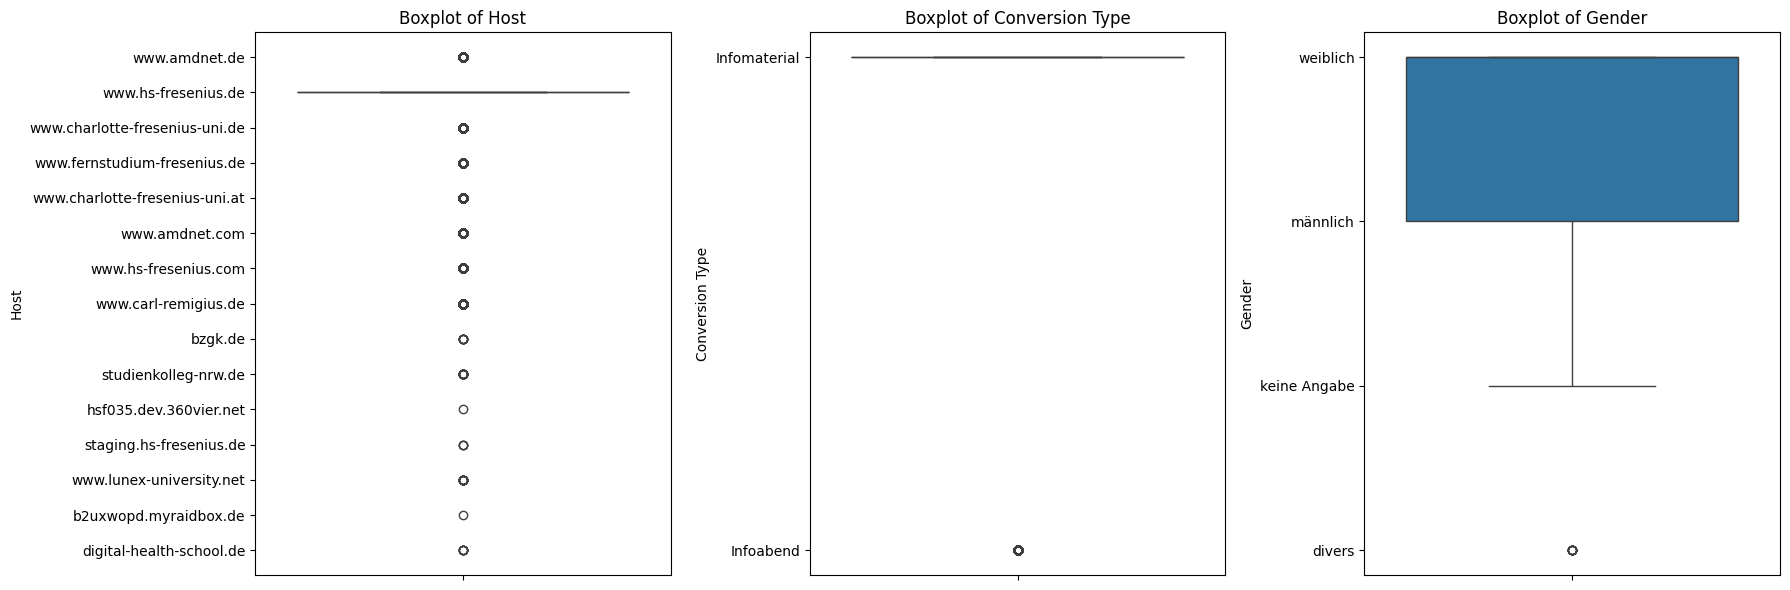

In [ ]:
# Histogramme
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.histplot(df[column], kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

In [ ]:
df['Host'].value_counts()

Host
www.hs-fresenius.de               131236
www.amdnet.de                      12679
www.hs-fresenius.com                7917
www.carl-remigius.de                7067
www.charlotte-fresenius-uni.de      6886
www.amdnet.com                      1578
www.fernstudium-fresenius.de        1503
www.charlotte-fresenius-uni.at      1297
studienkolleg-nrw.de                  23
www.lunex-university.net              16
bzgk.de                                7
digital-health-school.de               6
staging.hs-fresenius.de                3
hsf035.dev.360vier.net                 1
b2uxwopd.myraidbox.de                  1
Name: count, dtype: int64

In [ ]:
unwanted_hosts = ['staging.hs-fresenius.de', 'hsf035.dev.360vier.net', 'b2uxwopd.myraidbox.de', 'digital-health-school.de']

# Filter the DataFrame
df = df[~df['Host'].isin(unwanted_hosts)]

In [ ]:
unwanted_Lead_Source = ['-149307507Publisher', 'Not Found']

# Filter the DataFrame
df = df[~df['Lead Source'].isin(unwanted_Lead_Source )]

In [ ]:
df['Conversion Type'] = df['Conversion Type'].fillna('Infomaterial')

In [ ]:
df['Gender'] = df['Gender'].fillna('weiblich')

In [ ]:
df['Host'] = df['Host'].fillna('www.hs-fresenius.de')

In [ ]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Lead Source,0.0
Study Model,0.0
is_converted,0.0
Semester,0.0
Study Program,0.0
Faculty,0.0
Study Location,0.0
Type of Study Program,0.0
Conversion Type,0.0
Lead Source Detail,0.0


In [ ]:
df.describe()

,Sum of Study Interests
count,210797.0
mean,1.05613
std,0.279028
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,16.0


In [ ]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Lead Source,0
Study Model,0
is_converted,0
Semester,0
Study Program,0
Faculty,0
Study Location,0
Type of Study Program,0
Conversion Type,0
Lead Source Detail,0


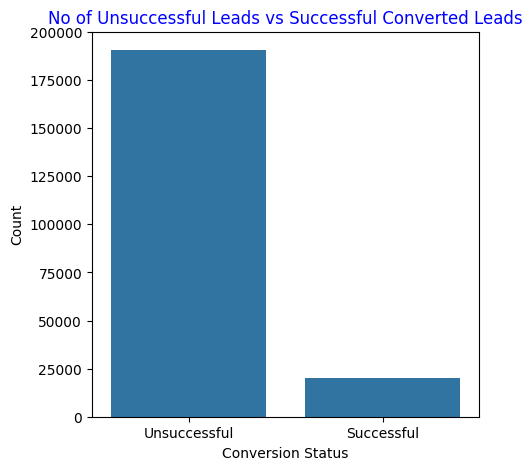

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_converted', data=df)
plt.title('No of Unsuccessful Leads vs Successful Converted Leads', color='blue')
plt.xticks(np.arange(2), ('Unsuccessful', 'Successful'))
plt.xlabel('Conversion Status')
plt.ylabel('Count')
plt.show()

In [ ]:
total_leads = len(df)
successful_leads = df['is_converted'].sum()
conversion_rate = (successful_leads / total_leads) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

Conversion Rate: 9.60%


In [ ]:
# Creating a crosstab DataFrame for demonstration
crosstab_df = pd.crosstab(index=df['Lead Source'], columns='count')

In [ ]:
def plot_frequency_and_percentage(feature, df, category_df, another_row=False, height=8, ylabels=[]):
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, height * 2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Get top 5 categories by frequency
    top_categories = category_df[feature].value_counts().nlargest(5).index

    # Frequency plot for top 5 categories
    ax1.set_title(f'Frequency Plot of {feature}', color='blue')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('count')
    sns.countplot(y=feature, data=category_df[category_df[feature].isin(top_categories)],
                  order=top_categories, ax=ax1, color='green')
    if ylabels:
        ax1.set_yticklabels(ylabels)

    # Calculate count of converted leads for top 5 categories
    converted_counts = df[df['is_converted'] == True][feature].value_counts()
    converted_counts = converted_counts[converted_counts.index.isin(top_categories)]

    # Converted leads plot for top 5 categories
    ax2.set_title('Converted Leads Count', color='blue')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('count')
    converted_counts.sort_values().plot(kind='barh', ax=ax2, color='orange')
    if ylabels:
        ax2.set_yticklabels(ylabels)

    # Calculate and display overall conversion rate
    total_leads = len(df)
    successful_leads = df['is_converted'].sum()
    conversion_rate = (successful_leads / total_leads) * 100
    fig.suptitle(f'Overall Conversion Rate: {conversion_rate:.2f}%', fontsize=14, color='red')


plt.show()

In [ ]:

def plot_conversion_rate(df, is_converted_column, feature):
    """
    Plots the conversion rate for a specified feature.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    is_converted_column (str): The name of the column indicating if a conversion occurred.
    feature (str): The feature for which to calculate and plot the conversion rate.
    """
    # Filter data where is_converted is True
    df_converted = df[df[is_converted_column] == True]

    # Calculate the count of conversions for each unique value in the feature
    converted_counts = df_converted[feature].value_counts()

    # Calculate the percentage of each unique value within the converted data
    conversion_rate = (converted_counts / converted_counts.sum()) * 100
    conversion_rate = conversion_rate.sort_values(ascending=False)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    conversion_rate.plot(kind='bar')
    plt.title(f'Percentage of Converted Users by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage of Converted Users (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

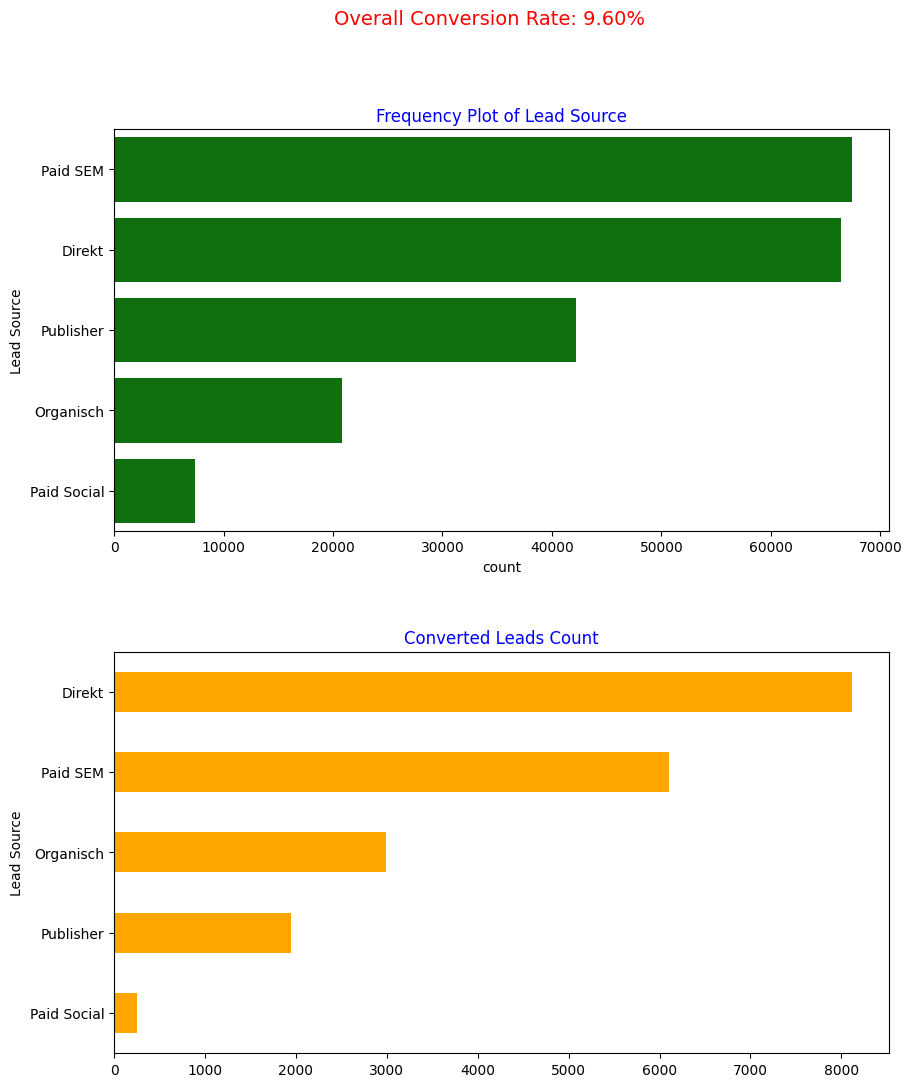

In [ ]:
plot_frequency_and_percentage('Lead Source', df, df, True, 6)

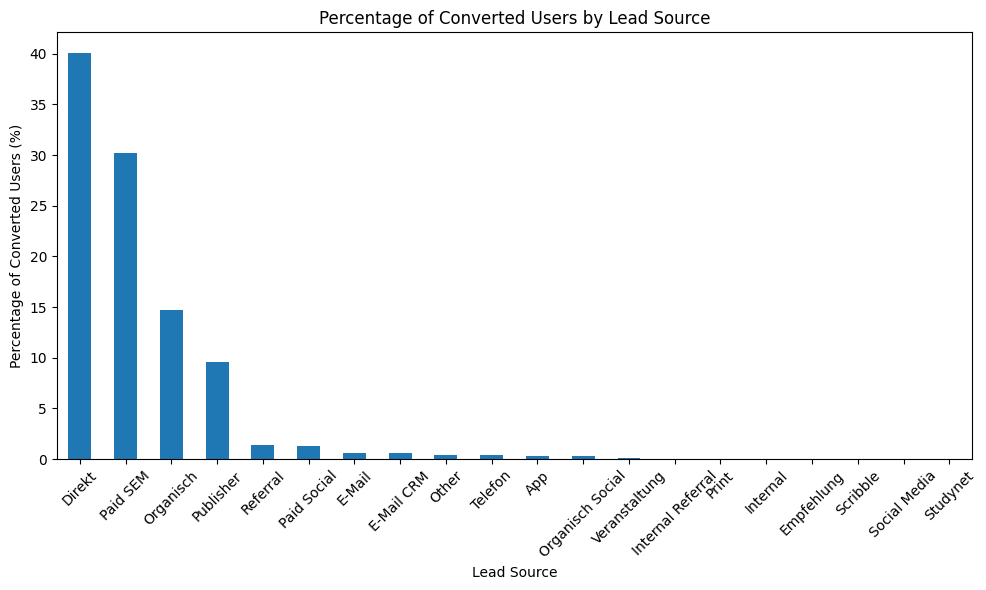

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Lead Source')

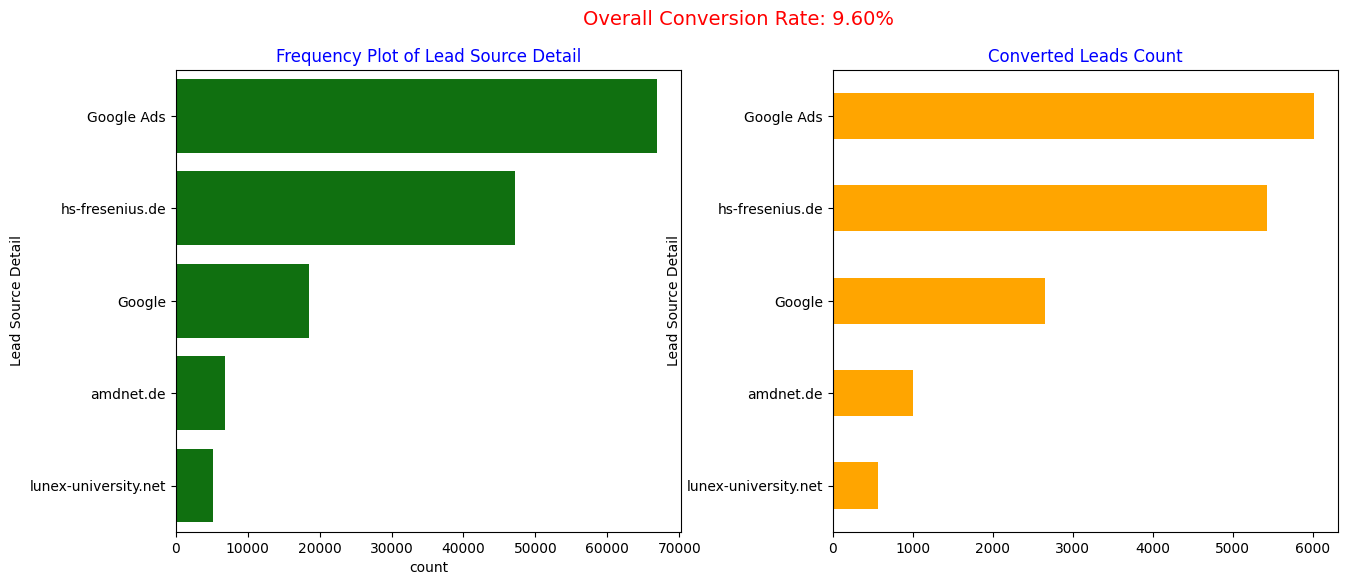

In [ ]:
#plot_frequency_and_percentage('Lead_Source_Detail', df, df, True, 6)
plot_frequency_and_percentage('Lead Source Detail', df, df, another_row=False, height=8, ylabels=[])

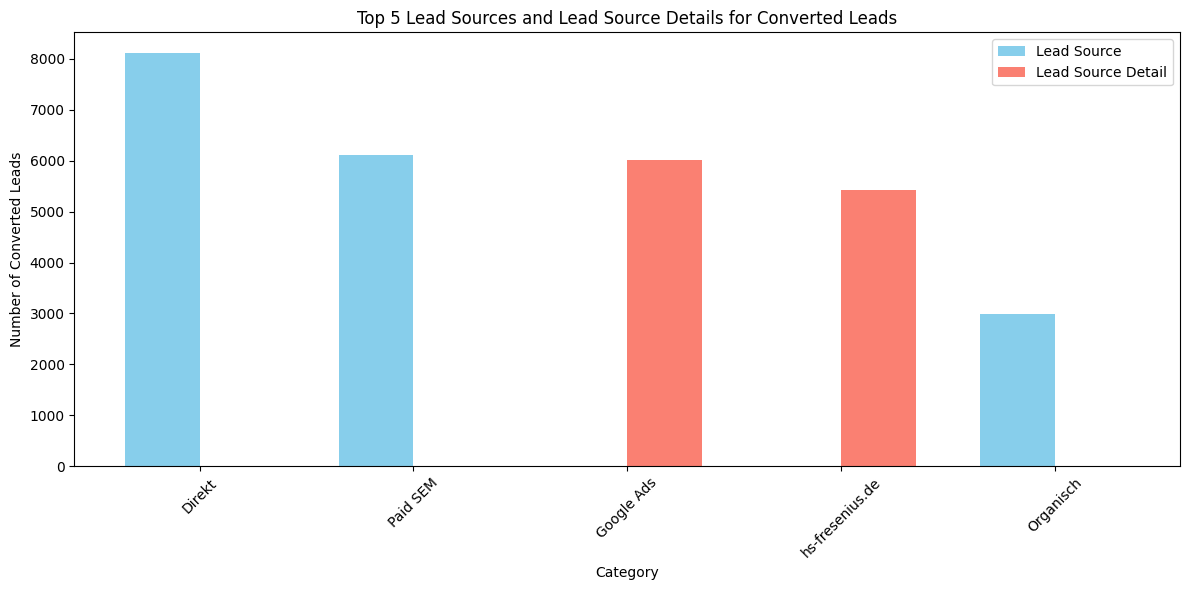

In [ ]:
# Filter for converted leads
converted_leads = df[df['is_converted'] == True]

# Aggregate the data for Lead Source and Lead Source Detail
lead_source_counts = converted_leads['Lead Source'].value_counts()
lead_source_detail_counts = converted_leads['Lead Source Detail'].value_counts()

# Combine the counts into a DataFrame
combined_counts = pd.concat([lead_source_counts, lead_source_detail_counts], axis=1).fillna(0)
combined_counts.columns = ['Lead Source', 'Lead Source Detail']

# Select the top 5 categories overall
top_combined_counts = combined_counts.sum(axis=1).nlargest(5)
top_combined_counts = combined_counts.loc[top_combined_counts.index]

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = range(len(top_combined_counts))

# Plot Lead Source bars
lead_source_bars = ax.bar(index, top_combined_counts['Lead Source'], bar_width, label='Lead Source', color='skyblue')

# Plot Lead Source Detail bars next to Lead Source bars
lead_source_detail_bars = ax.bar([i + bar_width for i in index], top_combined_counts['Lead Source Detail'], bar_width, label='Lead Source Detail', color='salmon')

# Add labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Number of Converted Leads')
ax.set_title('Top 5 Lead Sources and Lead Source Details for Converted Leads')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_combined_counts.index, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

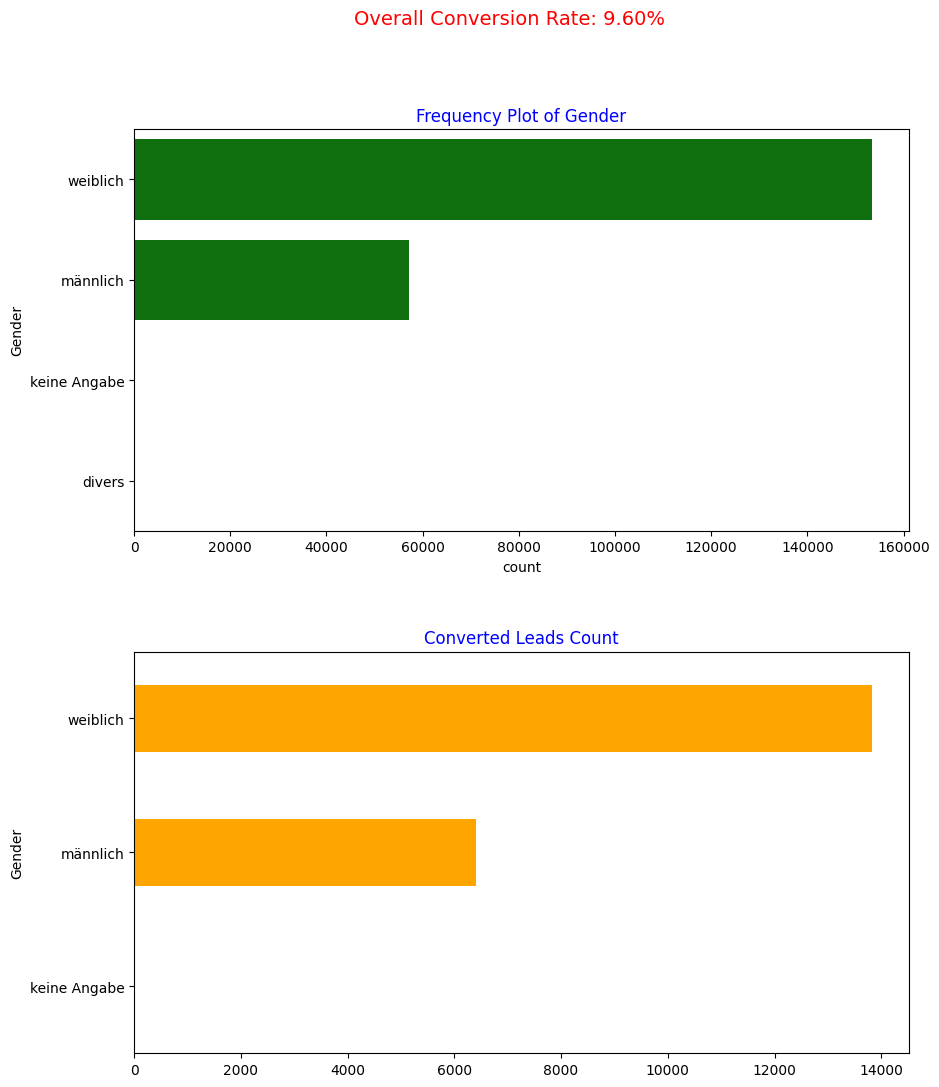

In [ ]:
plot_frequency_and_percentage('Gender', df, df, True, 6)

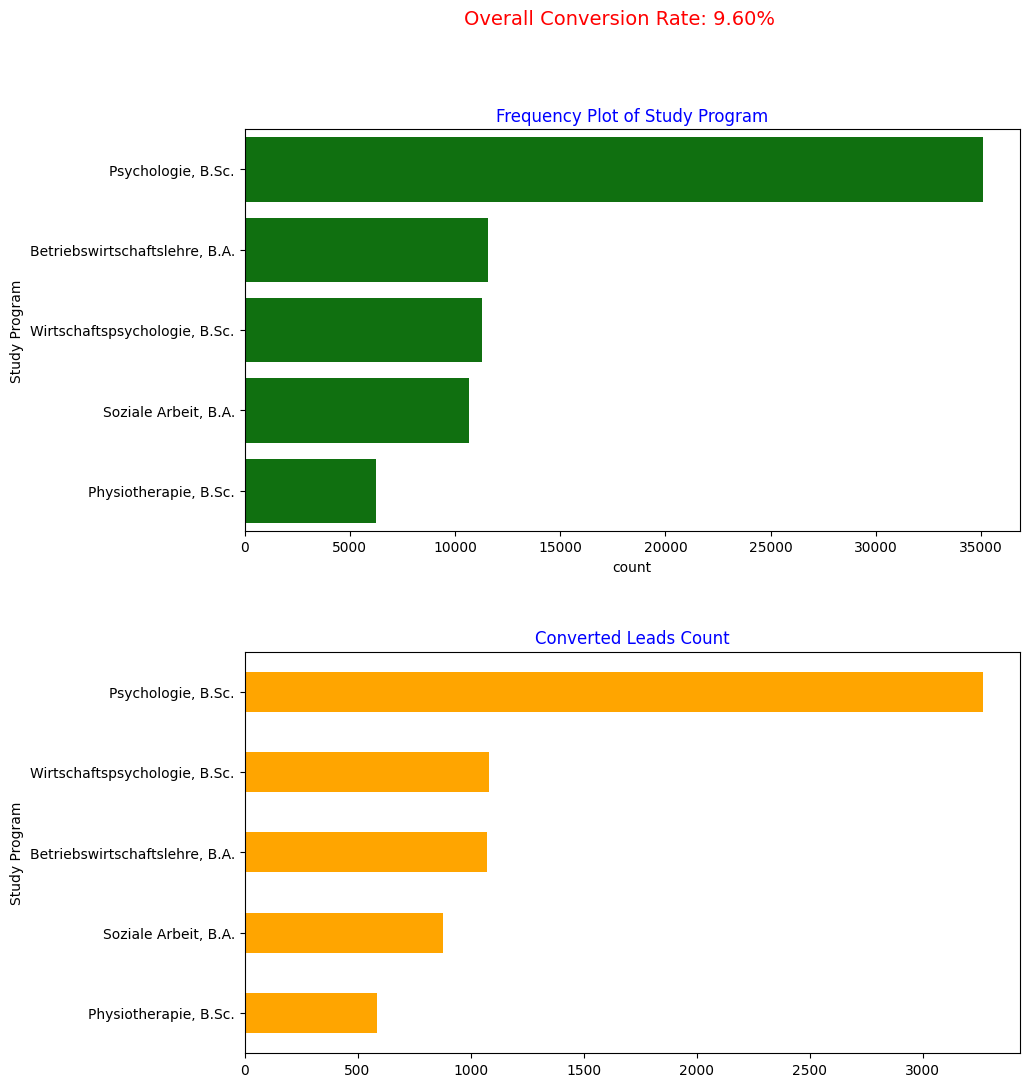

In [ ]:
plot_frequency_and_percentage('Study Program', df, df, True, 6)

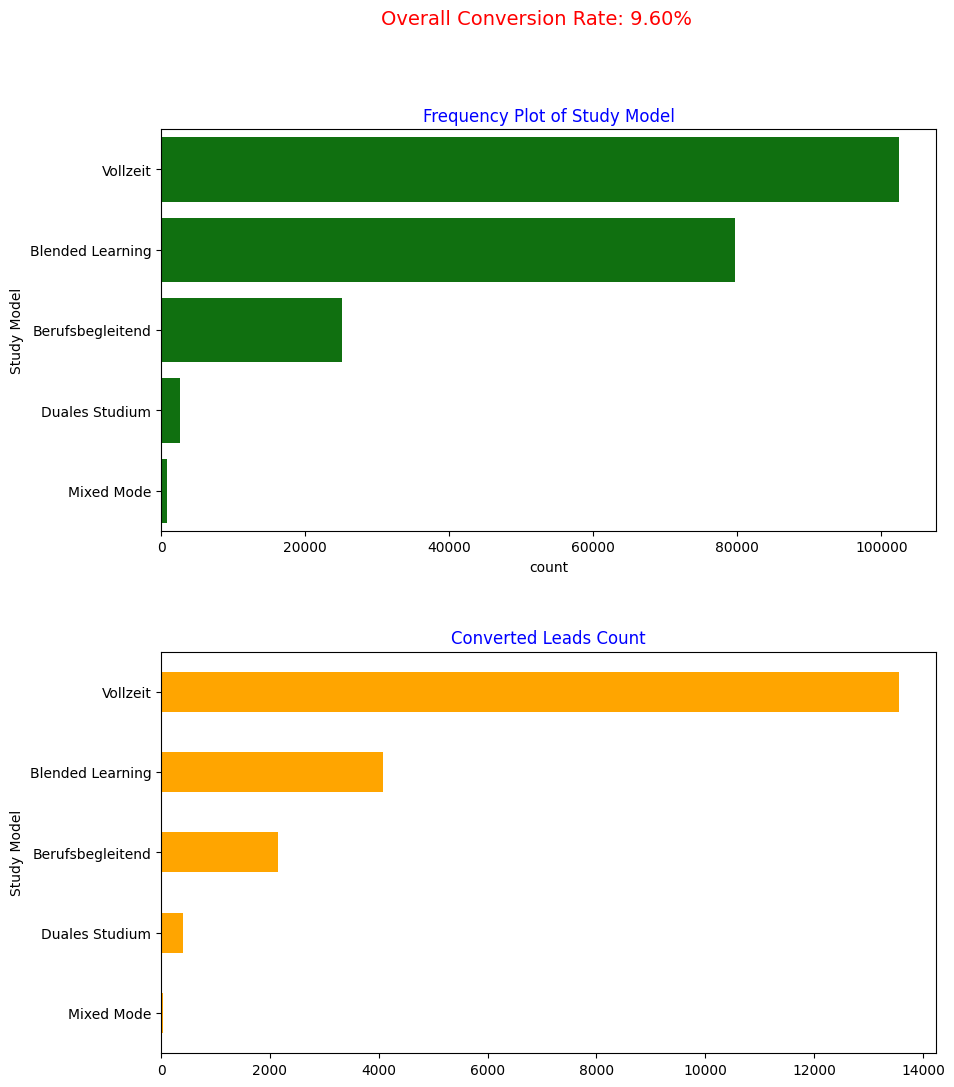

In [ ]:
plot_frequency_and_percentage('Study Model', df, df, True, 6)

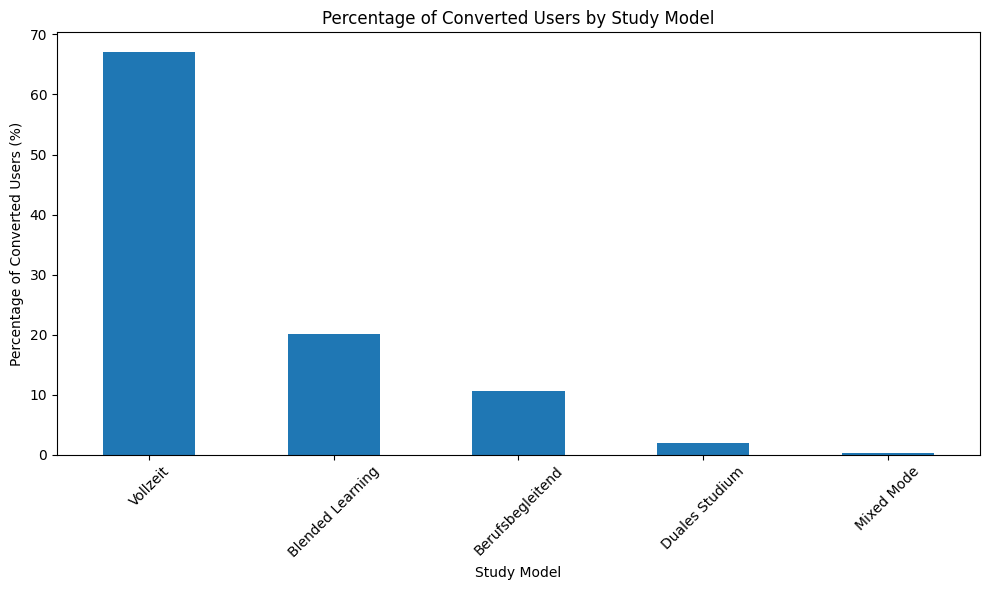

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Study Model')

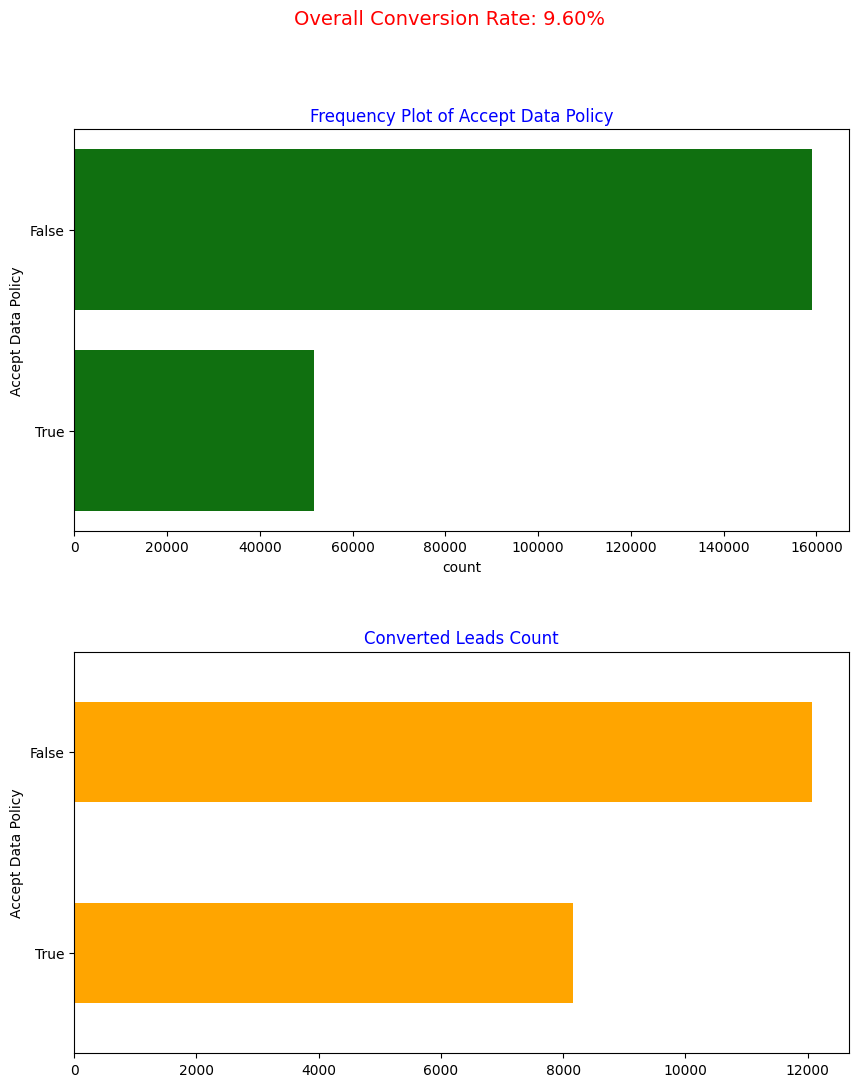

In [ ]:
plot_frequency_and_percentage('Accept Data Policy', df, df, True, 6)

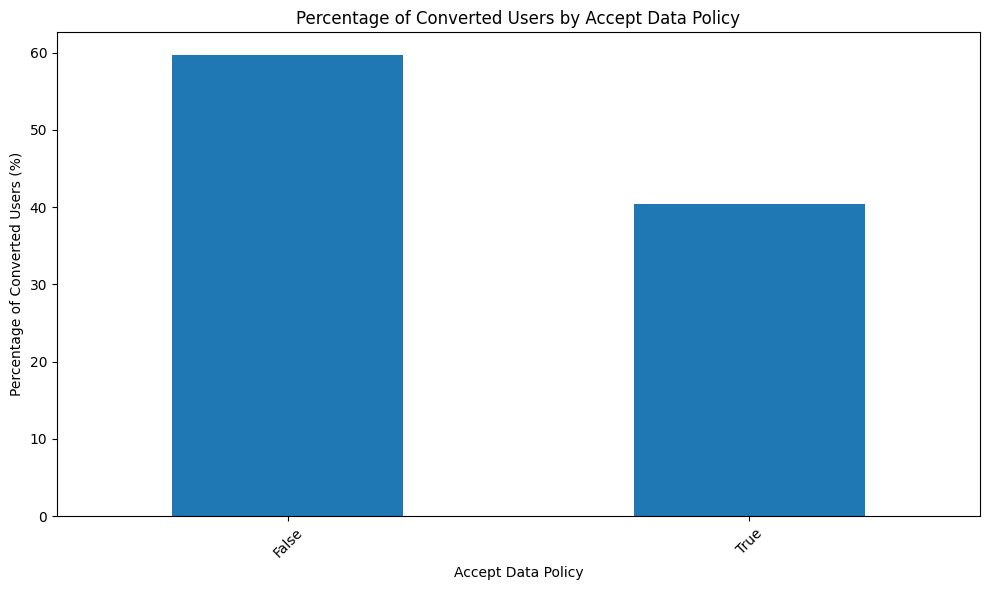

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Accept Data Policy')

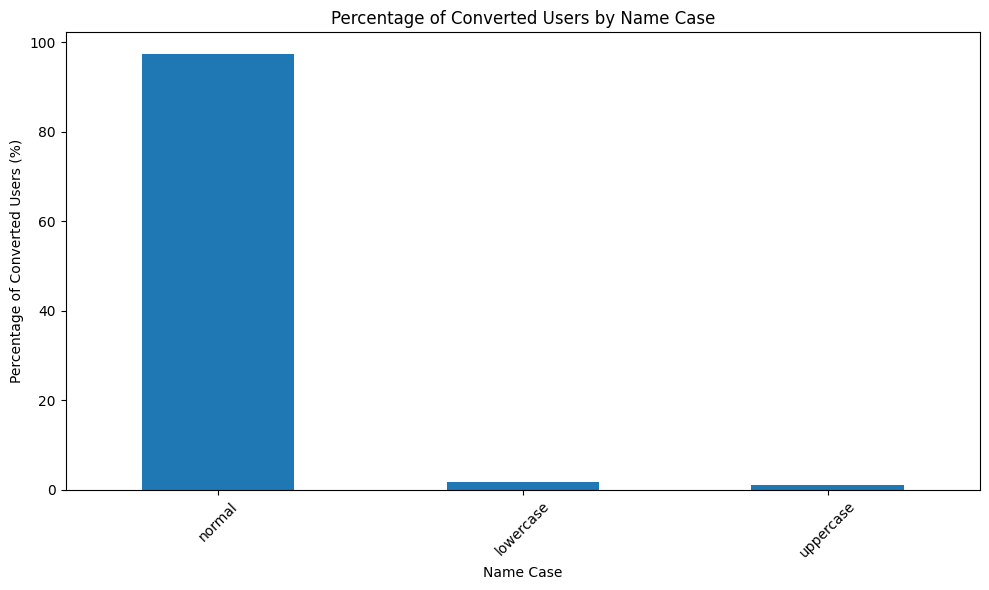

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Name Case')

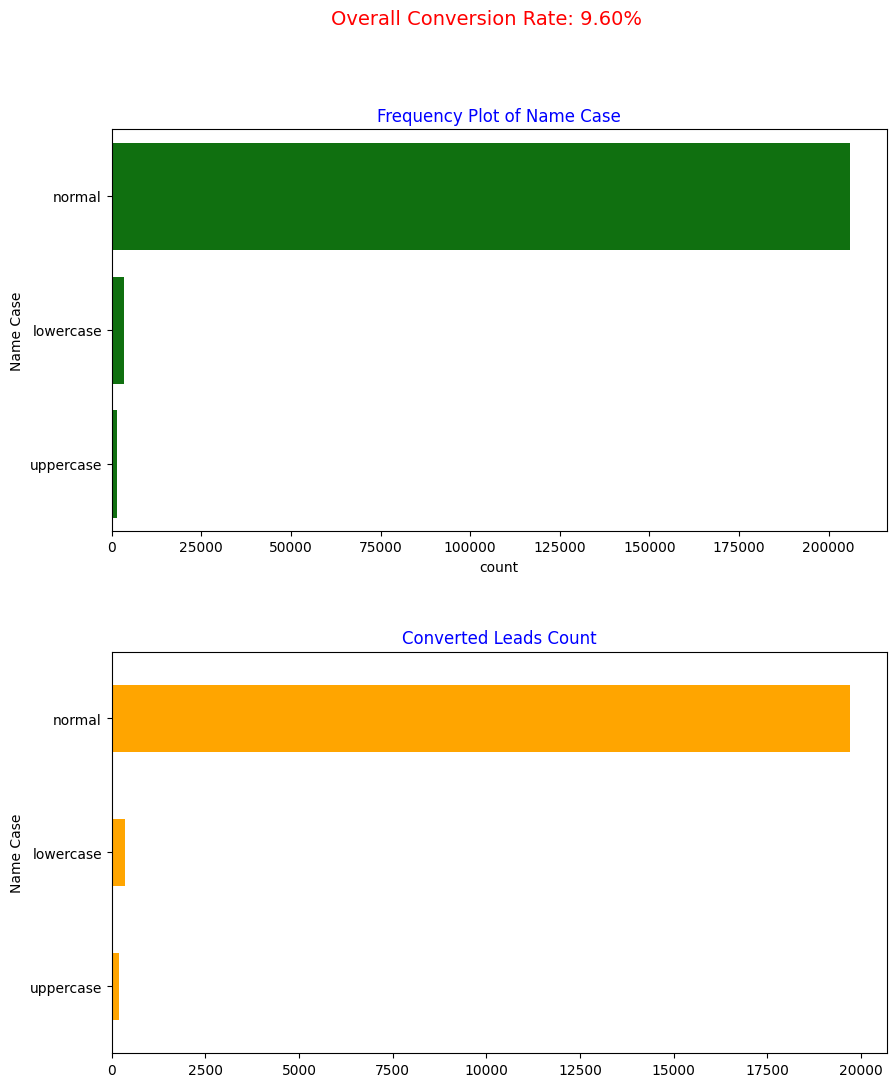

In [ ]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

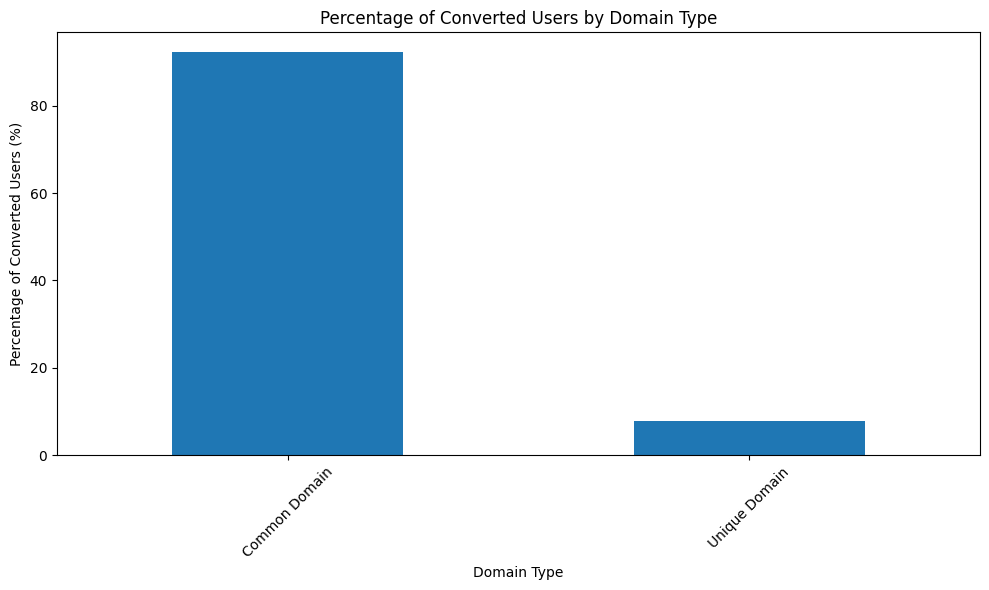

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Domain Type')

In [ ]:
filtered_df = df[df['is_converted'] == True]

# Step 3: Calculate the mean of 's_onTime' for the filtered DataFrame
s_onTime_mean_filtered = filtered_df['Sum of Study Interests'].mean()
print(s_onTime_mean_filtered)

1.1147670569635888


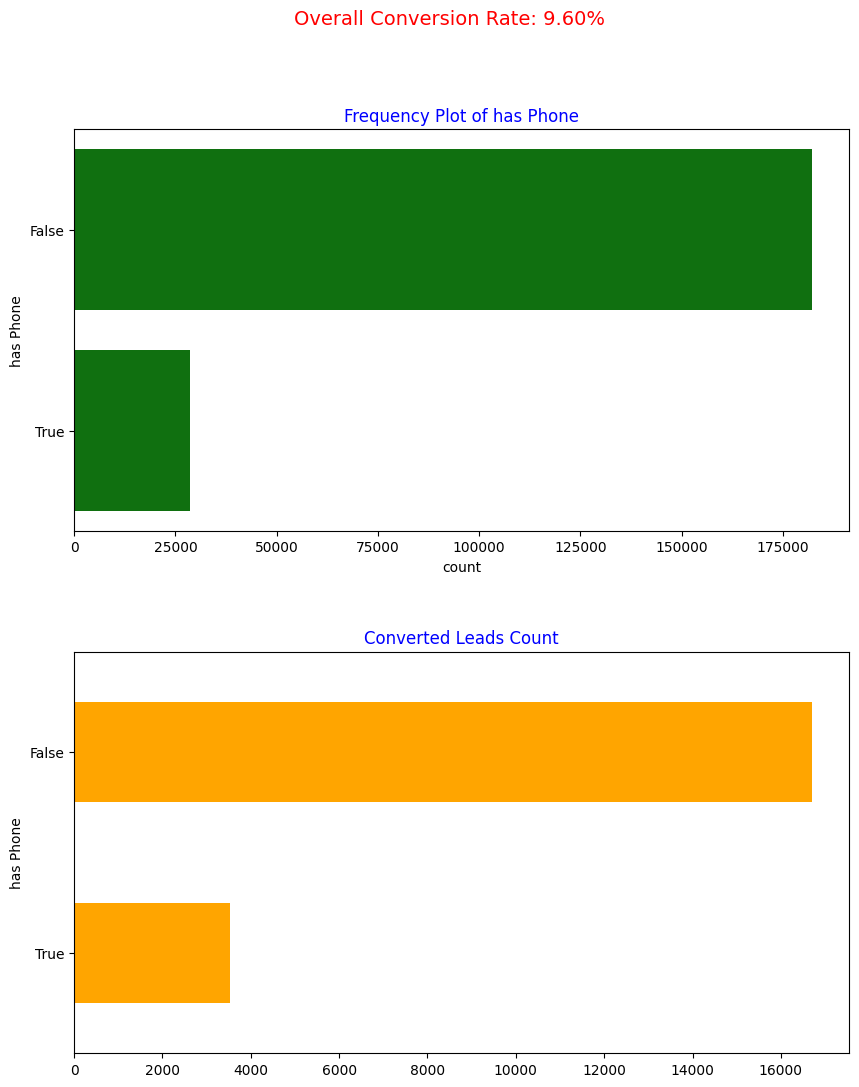

In [ ]:
plot_frequency_and_percentage('has Phone', df, df, True, 6)

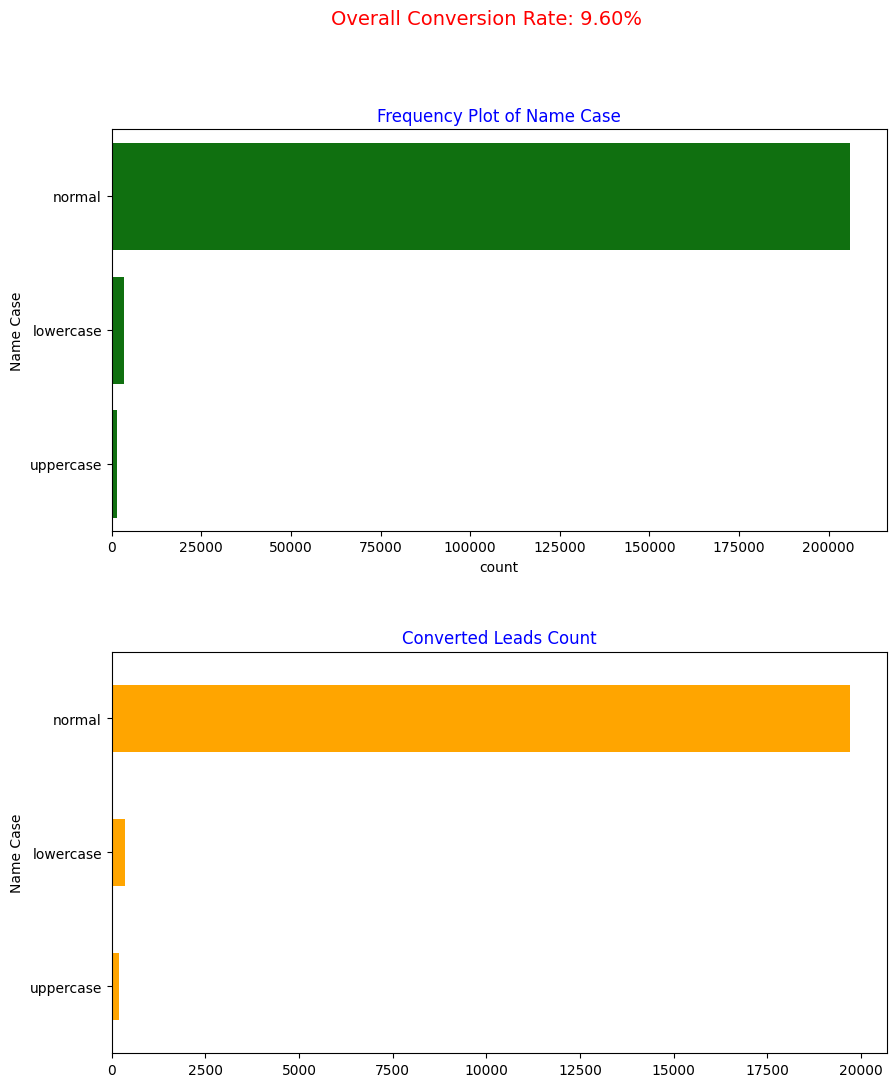

In [ ]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

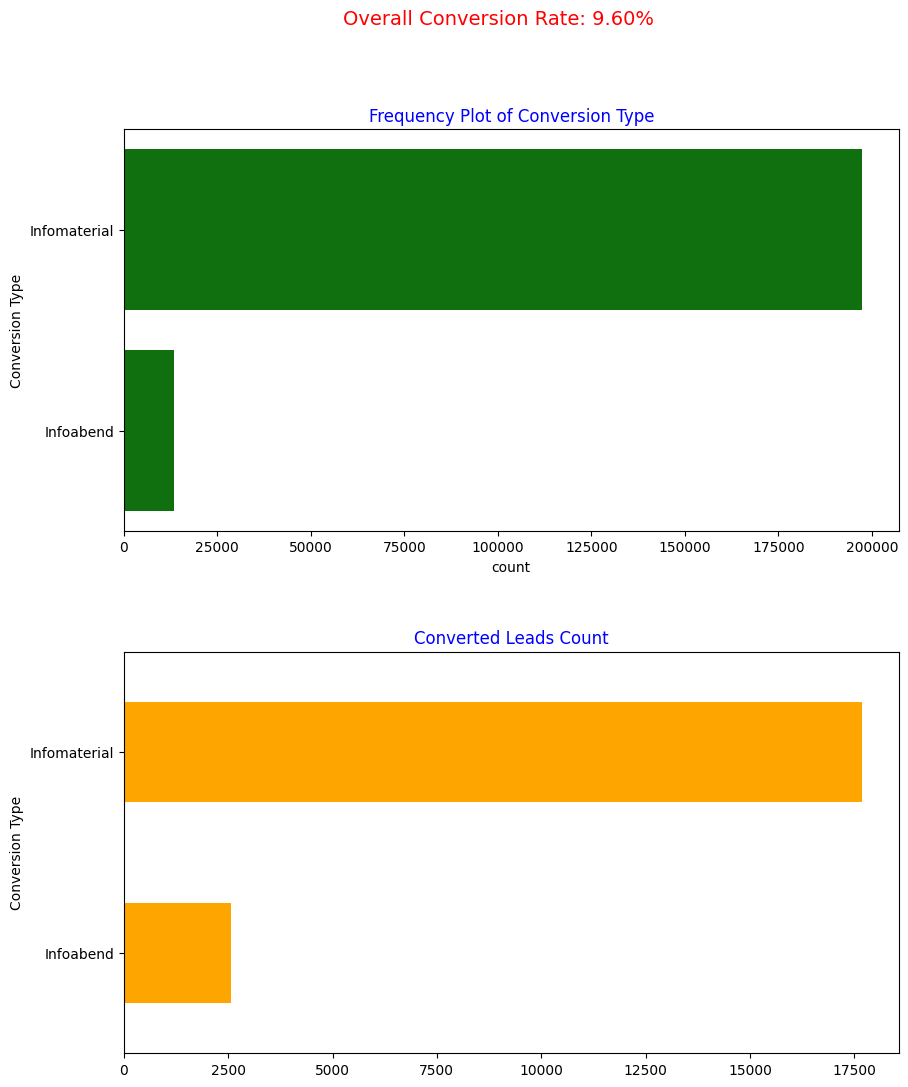

In [ ]:
plot_frequency_and_percentage('Conversion Type', df, df, True, 6)

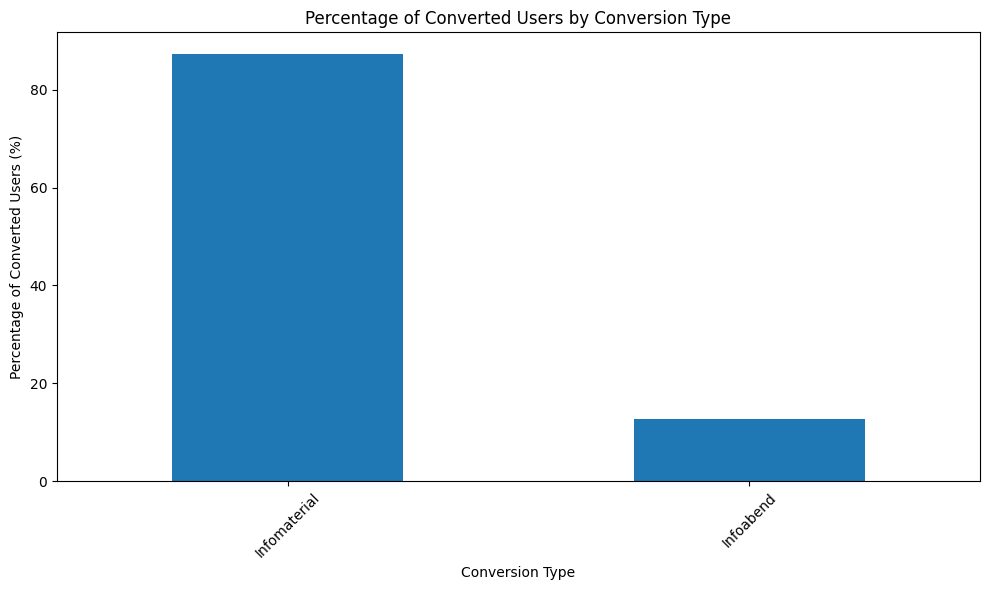

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Conversion Type')

In [ ]:
!pip install category_encoders --q

In [ ]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import category_encoders as ce

In [ ]:
df.dtypes

Lead Source                object
Lead Source Detail         object
Name Case                  object
Domain Type                object
Gender                     object
Host                       object
has Phone                 boolean
Accept Data Policy        boolean
Conversion Type            object
Study Model                object
Type of Study Program      object
Study Location             object
Faculty                    object
Study Program              object
Semester                   object
is_converted              boolean
Sum of Study Interests      Int64
dtype: object

In [ ]:
df.nunique()

Lead Source                24
Lead Source Detail        505
Name Case                   3
Domain Type                 2
Gender                      4
Host                       11
has Phone                   2
Accept Data Policy          2
Conversion Type             2
Study Model                 5
Type of Study Program       6
Study Location             19
Faculty                    10
Study Program             192
Semester                    2
is_converted                2
Sum of Study Interests     11
dtype: int64

In [ ]:
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold


# Define the categorical features and boolean features
target_features = ['Host', 'Conversion Type', 'Gender', 'Study Model', 'Faculty', 'Study Location',
                   'Type of Study Program', 'Lead Source', 'Domain Type', 'Name Case', 'Lead Source Detail',
                   'Study Program', 'Semester']

boolean_features = ['has Phone', 'Accept Data Policy']

# Step 1: Extract 'is_converted' column from df and assign to y
y = df['is_converted']

# Step 2: Drop the 'is_converted' column from df and assign the remaining DataFrame to X_temp
X_temp = df.drop(columns=['is_converted'])

# Step 3: Initialize the target encoder
target_encoder = TargetEncoder()

# Step 4: Fit the encoder on the training data and transform the categorical features in X_temp
X_encoded = target_encoder.fit_transform(X_temp[target_features], y)

# Step 5: Initialize Label Encoder for boolean features
label_encoder = LabelEncoder()

# Step 6: Label encode the boolean features
for feature in boolean_features:
    X_temp[feature] = label_encoder.fit_transform(X_temp[feature])

# Step 7: Combine encoded categorical features with the original dataframe excluding the target features
X_combined = X_temp.drop(columns=target_features).join(X_encoded)


In [ ]:
# Scale the 'Sum of Study Interests' feature
scaler = StandardScaler()
X_combined ['Sum of Study Interests'] = scaler.fit_transform(X_combined [['Sum of Study Interests']])
X_prep = X_combined

In [ ]:
lb = LabelEncoder()
lb.fit(y)
y_encoded = lb.transform(y)
print("Encoded labels:",lb.classes_)
y_en = pd.Series(y_encoded)

Encoded labels: [0. 1.]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_en, test_size=0.3, stratify=y, random_state=42)


print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (147557, 16) (147557,)
Test Data Shape :  (63240, 16) (63240,)


In [ ]:
from imblearn.over_sampling import SMOTE
smote= SMOTE(random_state=42)
# Fit and resample the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (266776, 16) (266776,)
Test Data Shape :  (63240, 16) (63240,)


In [ ]:
# Compute Mutual Information scores
mi_classification = mutual_info_classif(X_train, y_train, discrete_features='auto')

# Create a pandas Series with the MI scores and the feature names
mi_series = pd.Series(mi_classification, index=X_train.columns)

# Exclude the specified column
mi_series = mi_series.drop(labels='Sum of Study Interests')

# Sort the MI scores in descending order and convert to a DataFrame
data_mi = mi_series.sort_values(ascending=False).to_frame(name='MI')

# Display the DataFrame
print(data_mi)


                             MI
Study Program          0.223405
Study Location         0.140670
Lead Source Detail     0.117772
Type of Study Program  0.070853
Lead Source            0.066429
Faculty                0.064583
Gender                 0.053791
Study Model            0.045479
Domain Type            0.040187
Name Case              0.038626
Host                   0.037229
Semester               0.034119
Conversion Type        0.028286
Accept Data Policy     0.024919
has Phone              0.002580


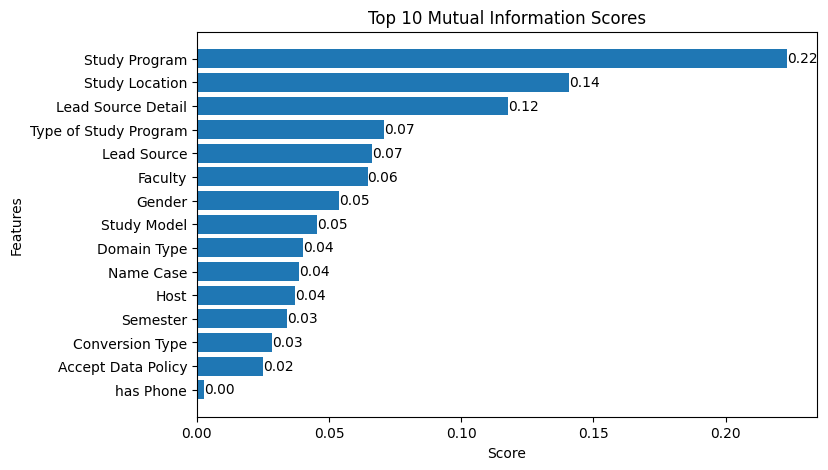

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the Mutual Information scores
def plot_mi_scores(scores):
    # Select top 10 scores
    top_scores = scores.sort_values(ascending=False).head(30)
    sorted_scores = top_scores.sort_values(ascending=True)
    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Top 10 Mutual Information Scores")
    plt.xlabel("Score")
    plt.ylabel("Features")

    # Add text annotations for the bar values
    for index, value in enumerate(sorted_scores):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left')

    plt.show()

# Plot the Mutual Information scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_series)



In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import f_classif
from scipy import stats

X = df[['Sum of Study Interests']]
y = df['is_converted']

# Apply ANOVA F-test
f_values, p_values = f_classif(X, y)

# Create a DataFrame to display the F-scores and p-values for the specific feature
anova_results = pd.DataFrame({
    'Feature': ['Sum of Study Interests'],
    'F-Score': f_values,
    'p-Value': p_values
})

# Select the feature (in this case, it's already just one)
selected_feature = anova_results.iloc[0]

print("Selected feature based on ANOVA F-test:")
print(selected_feature)

Selected feature based on ANOVA F-test:
Feature    Sum of Study Interests
F-Score                 993.49306
p-Value                       0.0
Name: 0, dtype: object


In [ ]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test)[:, 1]
    else:
        proba = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)

    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")

    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

In [ ]:
# Define the DNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# Define the DNN model
def create_dnn_model(input_dim, num_neurons_1=32, num_neurons_2=16, activation_1='relu', activation_2='relu', optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(num_neurons_1, input_dim=input_dim, activation=activation_1))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_neurons_2, activation=activation_2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
# Pipelines for each model
pipeline_xgb = Pipeline([
    ('clf', xgb.XGBClassifier())
])

pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier())
])

pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])


pipeline_dnn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KerasClassifier(build_fn=create_dnn_model, input_dim=X_train.shape[1], verbose=0))
])

<ipython-input-105-635b3895e2ca>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('clf', KerasClassifier(build_fn=create_dnn_model, input_dim=X_train.shape[1], verbose=0))


In [ ]:
model_performance = {}

XGBoost Metrics:
Accuracy: 0.8203668564199873
Precision: 0.20790985417587274
Recall (Sensitivity): 0.3099472990777339
F1-Score: 0.24887595874107382
Specificity: 0.8745801847187238
ROC AUC: 0.6897620152534729


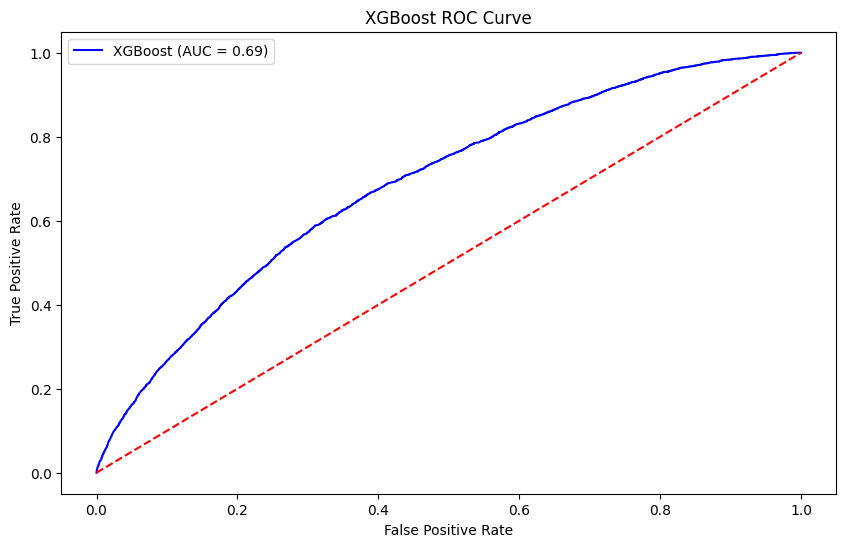

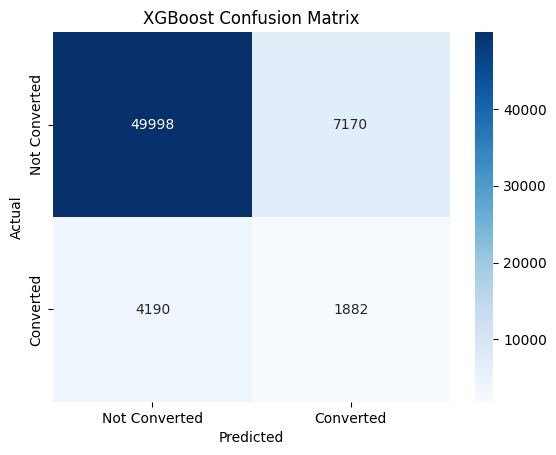

In [ ]:

# Train and evaluate XGBoost
model_performance['XGBoost'] = evaluate_model(pipeline_xgb.fit(X_train, y_train),X_test, y_test, "XGBoost")

RandomForest Metrics:
Accuracy: 0.8185641998734978
Precision: 0.18882488479262674
Recall (Sensitivity): 0.26992753623188404
F1-Score: 0.22220715835141
Specificity: 0.8768366918555835
ROC AUC: 0.6377606756518568


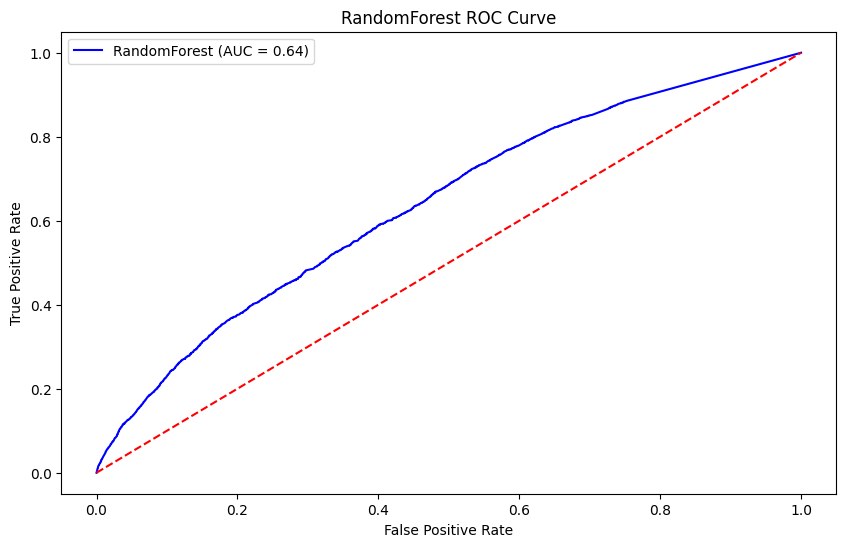

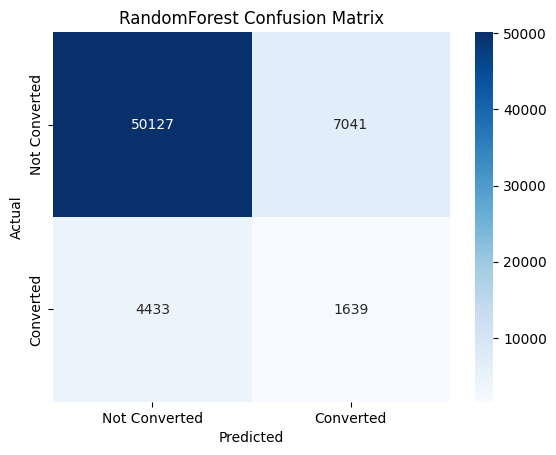

In [ ]:

# Train and evaluate RandomForest
model_performance['RandomForest'] = evaluate_model(pipeline_rf.fit(X_train, y_train), X_test, y_test, "RandomForest")

DecisionTree Metrics:
Accuracy: 0.8131878557874763
Precision: 0.18304261426363436
Recall (Sensitivity): 0.2730566534914361
F1-Score: 0.21916721744877724
Specificity: 0.8705569549398264
ROC AUC: 0.5882123118298304


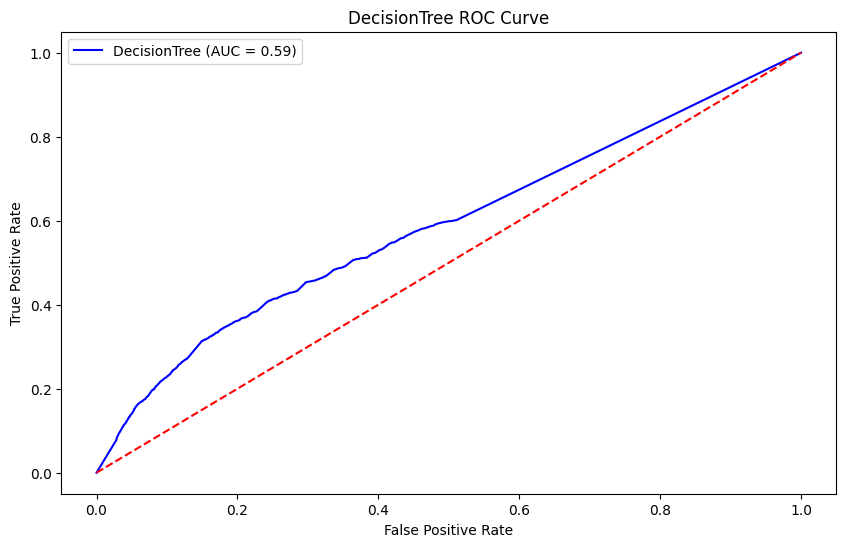

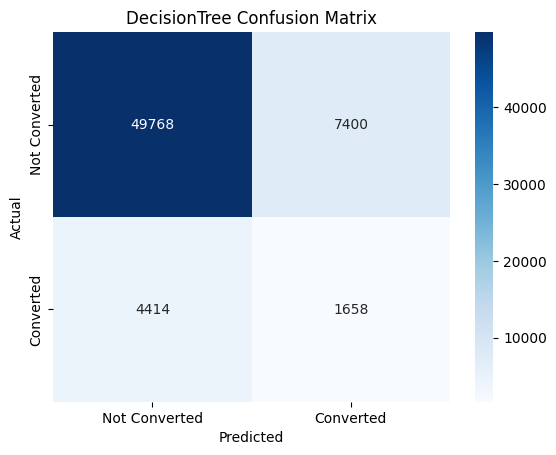

In [ ]:

# Train and evaluate DecisionTree
model_performance['DecisionTree'] = evaluate_model(pipeline_dt.fit(X_train, y_train), X_test, y_test, "DecisionTree")

1977/1977 [==============================] - 2s 856us/step
Deep Neural Network Metrics:
Accuracy: 0.7075901328273245
Precision: 0.17906976744186046
Recall (Sensitivity): 0.5706521739130435
F1-Score: 0.27259853670049566
Specificity: 0.7221347607052897
ROC AUC: 0.7048261394680017


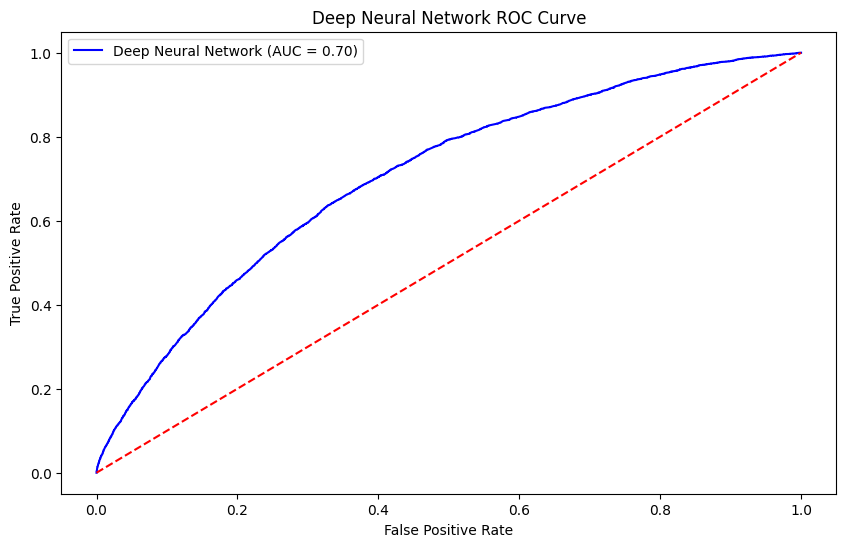

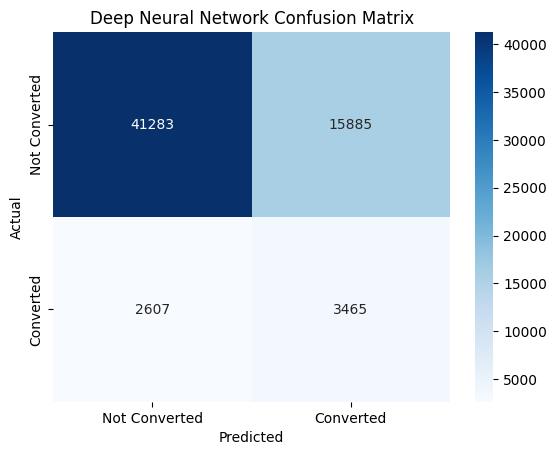

In [ ]:
model_performance['DNN'] = evaluate_model(pipeline_dnn.fit(X_train, y_train), X_test, y_test, "Deep Neural Network")

In [ ]:
# Print the performance metrics
for model_name, metrics in model_performance.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


XGBoost Performance:
accuracy: 0.8204
precision: 0.2079
recall: 0.3099
f1: 0.2489
roc_auc: 0.6898
specificity: 0.8746

RandomForest Performance:
accuracy: 0.8186
precision: 0.1888
recall: 0.2699
f1: 0.2222
roc_auc: 0.6378
specificity: 0.8768

DecisionTree Performance:
accuracy: 0.8132
precision: 0.1830
recall: 0.2731
f1: 0.2192
roc_auc: 0.5882
specificity: 0.8706

DNN Performance:
accuracy: 0.7076
precision: 0.1791
recall: 0.5707
f1: 0.2726
roc_auc: 0.7048
specificity: 0.7221


In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save the DataFrame to an Excel file
results_df.to_excel('model_performance_results5.xlsx', index=True)
print("Model performance results saved to 'model_performance_results_final.xlsx'.")

Model performance results saved to 'model_performance_results_final.xlsx'.


In [ ]:
from scipy.stats import uniform
# Extreme parameter grid for XGBoost
param_extreme_xgb = {
    'clf__max_depth': [1, 3, 5, 7, 9, 11, 13],
    'clf__learning_rate': uniform(0.0001, 0.5),
    'clf__n_estimators': [50, 100, 200, 300, 500],
    'clf__subsample': uniform(0.1, 0.9),
    'clf__colsample_bytree': uniform(0.1, 0.9),
    'clf__gamma': uniform(0, 1),
    'clf__min_child_weight': [1, 3, 5, 7, 9],
    'clf__reg_alpha': uniform(0, 1),
    'clf__reg_lambda': uniform(0, 2)
}

# Extreme parameter grid for Random Forest
param_extreme_rf = {
    'clf__n_estimators': [50, 100, 200, 300, 500, 1000],
    'clf__max_depth': [None, 5, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2, 5, 10, 15, 20],
    'clf__min_samples_leaf': [1, 2, 4, 8],
    'clf__max_features': ['auto', 'sqrt', 'log2', None],
    'clf__bootstrap': [True, False]
}

# Extreme parameter grid for Decision Tree
param_extreme_dt = {
    'clf__max_depth': [None, 5, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2, 5, 10, 15, 20],
    'clf__min_samples_leaf': [1, 2, 4, 8],
    'clf__max_features': ['auto', 'sqrt', 'log2', None]
}

# Extreme parameter grid for DNN

param_extreme_dnn = {
    'clf__num_neurons_1': [16, 32, 64, 128],
    'clf__num_neurons_2': [8, 16, 32, 64],
    'clf__activation_1': ['relu', 'tanh', 'sigmoid'],
    'clf__activation_2': ['relu', 'tanh', 'sigmoid'],
    'clf__dropout_rate': uniform(0, 0.5),
    'clf__optimizer': ['adam', 'rmsprop', 'sgd'],
    'clf__epochs': [50, 100, 200],
    'clf__batch_size': [16, 32, 64, 128]
}


In [ ]:
from sklearn.model_selection import StratifiedKFold
# Function to perform randomized search
def perform_randomized_search(pipeline, param_distributions, X_train, y_train, n_iter=100):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                       n_iter=n_iter, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search

In [ ]:
model_performance = {}


In [ ]:
random_search_xgb = perform_randomized_search(pipeline_xgb, param_extreme_xgb, X_train, y_train)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost Metrics:
Accuracy: 0.8239879822896901
Precision: 0.1989048922747292
Recall (Sensitivity): 0.27519762845849804
F1-Score: 0.23091273405651905
Specificity: 0.8822767982087881
ROC AUC: 0.6533311115918614


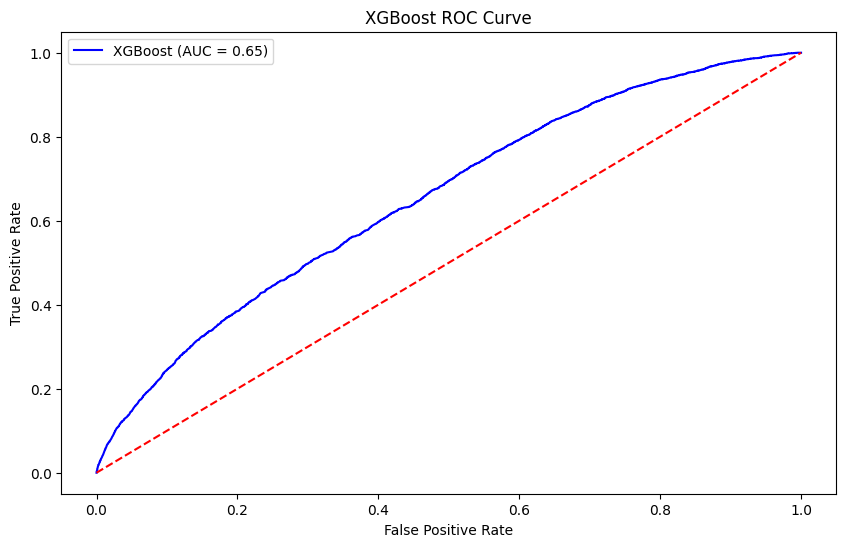

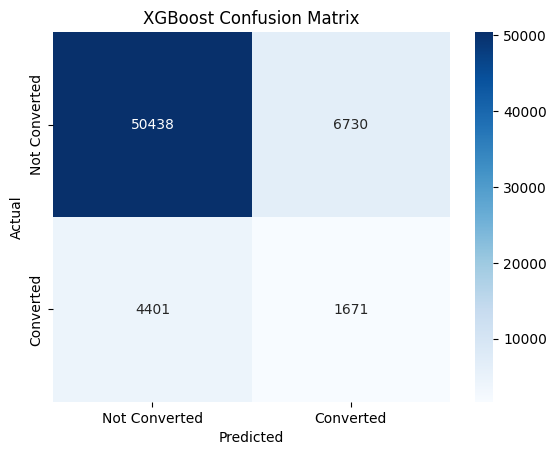

In [ ]:
model_performance['XGBoost'] = evaluate_model(random_search_xgb, X_test, y_test, 'XGBoost')

In [ ]:
random_search_rf = perform_randomized_search(pipeline_rf, param_extreme_rf, X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomForest Metrics:
Accuracy: 0.8232289690069576
Precision: 0.1912707048724459
Recall (Sensitivity): 0.2605401844532279
F1-Score: 0.22059541239629085
Specificity: 0.8829939826476351
ROC AUC: 0.6655003474607537


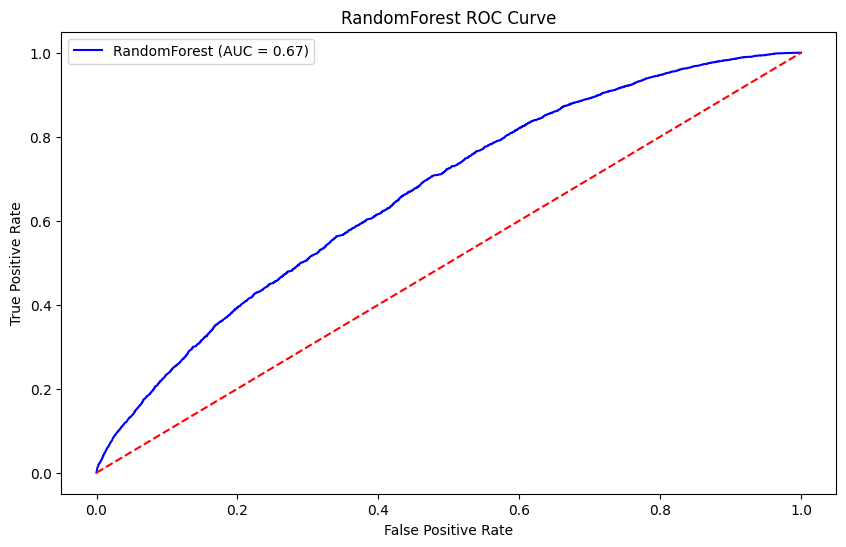

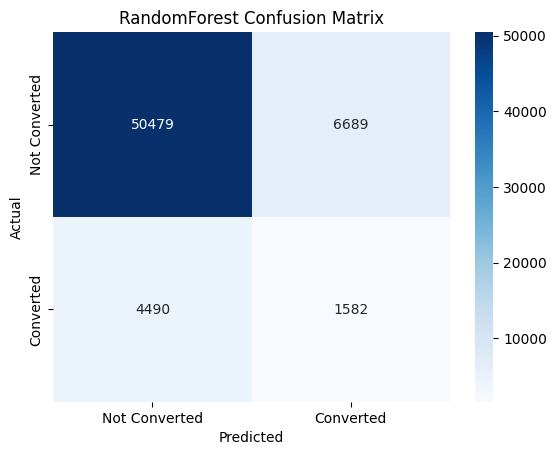

In [ ]:
model_performance['RandomForest'] = evaluate_model(random_search_rf, X_test, y_test, 'RandomForest')

In [ ]:
random_search_dt = perform_randomized_search(pipeline_dt, param_extreme_dt, X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


DecisionTree Metrics:
Accuracy: 0.814674256799494
Precision: 0.1839041862547571
Recall (Sensitivity): 0.2705862977602108
F1-Score: 0.21897907503665198
Specificity: 0.872463616008956
ROC AUC: 0.6208120207823313


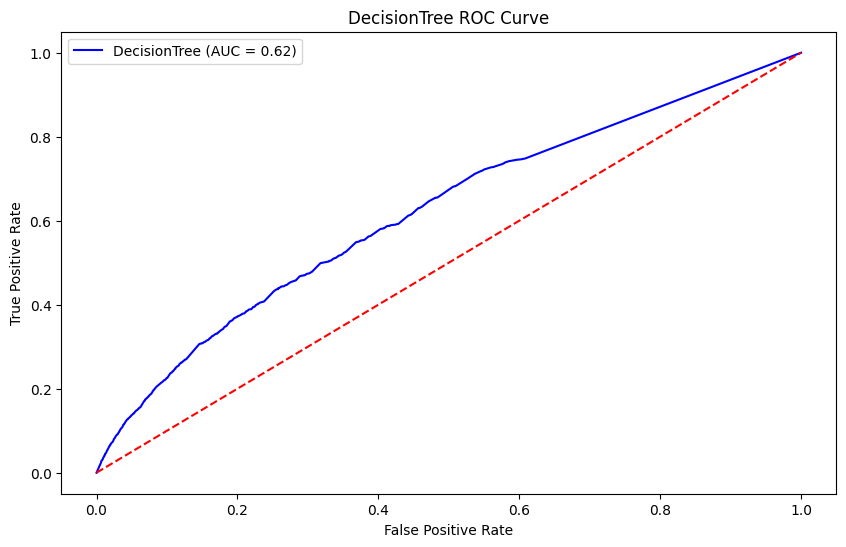

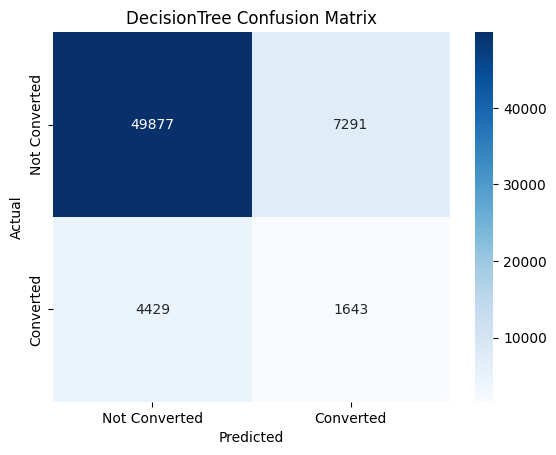

In [ ]:
model_performance['DecisionTree'] = evaluate_model(random_search_dt, X_test, y_test, 'DecisionTree')

In [ ]:
random_search_dnn = perform_randomized_search(pipeline_dnn, param_extreme_dnn, X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
model_performance['DNN'] = evaluate_model(random_search_dnn, X_test, y_test, "Deep Neural Network")

In [ ]:
# Print the performance metrics
for model_name, metrics in model_performance.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

In [ ]:
# Print the best parameters
print("\nBest Parameters:")
print(perform_randomized_search.best_params_)

In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save results to an Excel file
results_df.to_excel('model_performance_metrics_final.xlsx', index=True)

# Print results for each model
print("Model Performance Metrics:")
print(results_df)
